# Generic PCM Photochemistry postprocessing and visualization demonstrator

This Notebook will show you how to use the Generic PCM photochemistry postprocessing library and how to make interactive visualization with it. For it to work, you'll need to copy the *photochemistry_postprocessing.py* file along this notebook in the directory containing the output file (*diagfi.nc*) as well as the reaction network file chemnetwork/reactfile (to become *reaction.def*).

## Loading simulation and calculating reaction rates

In [1]:
import photochem_postproc as pcpp

sim_path        = 'H2O2/3D/start_no_CO'
NetCDF_filename = 'diagfi61'

# The simu class is just a wrapper for xr.Dataset
my_sim = pcpp.GPCM_simu(sim_path,NetCDF_filename)

H2O2/3D/start_no_CO/diagfi61 loaded, simulations lasts 60.541668 sols


Now let's try to calculate automatically the rates of all reactions found in the reactfile

In [2]:
my_sim = pcpp.compute_rates(my_sim)

# We can see that species list have been added
# to the simu object (as well as reactions dict)
print(my_sim.species)

reaction  no + hv -> n + o seems to be hard-coded. Add it manually if needed.
reaction  co + oh -> co2 + h seems to be hard-coded. Add it manually if needed.
['o2', 'o', 'o1d', 'o3', 'h2o2', 'oh', 'h2o_vap', 'h', 'co2', 'co', 'ho2', 'h2']


Some reactions' rates are hard-coded and need to be added manually (you should find their rates in *reaction_rate_lib.py*). To do that we first need to define a new reaction and call again **compute_rates** with the new reaction as second argument:

In [4]:
# First load the parametrization for its rate
from reaction_rate_lib import k_JPL_2015

# Then create the reaction objet (here for the reaction co + oh -> co2 + h):
hard_coded_reaction = pcpp.reaction(['co','oh'],['co2','h'],k_JPL_2015)

# Finally, add it to the reactions of my_sim
my_sim = pcpp.compute_rates(my_sim,{'co + oh -> co2 + h':hard_coded_reaction})

## Now let's do some visualization

### Static visualization
Here we use the built-in visualization methods of the *simu* class.

In [5]:
import matplotlib.pyplot as plt

#### Meridional slice

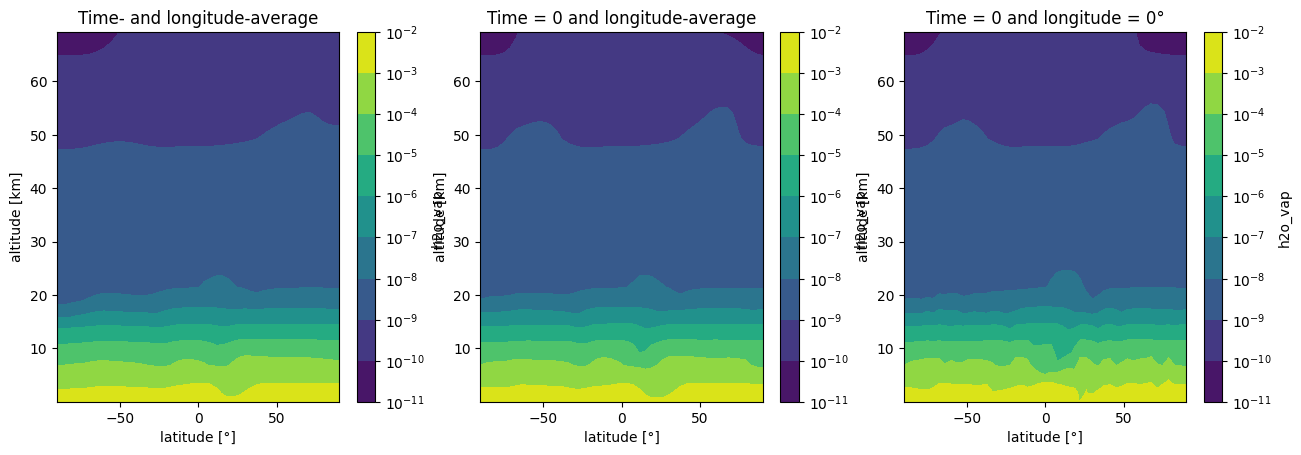

In [6]:
plt.subplot(131)
my_sim.plot_meridional_slice('h2o_vap',logcb=True)
plt.title('Time- and longitude-average')

plt.subplot(132)
my_sim.plot_meridional_slice('h2o_vap',logcb=True,t=0)
plt.title('Time = 0 and longitude-average')

plt.subplot(133)
my_sim.plot_meridional_slice('h2o_vap',logcb=True,t=0,lon=0)
plt.title('Time = 0 and longitude = 0°')

plt.subplots_adjust(right=2)

#### Time evolution

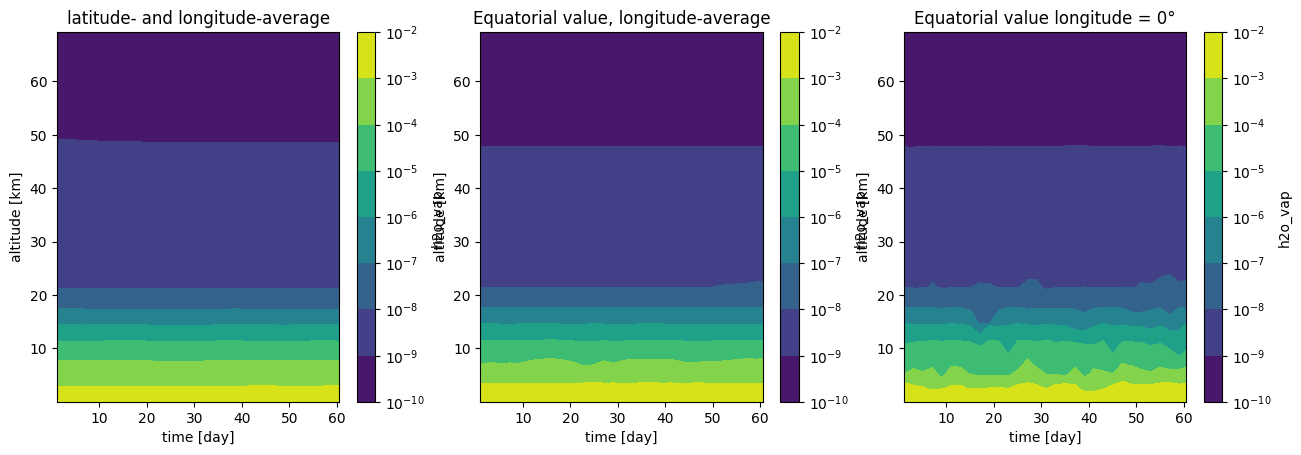

In [7]:
plt.subplot(131)
my_sim.plot_time_evolution('h2o_vap',logcb=True)
plt.title('latitude- and longitude-average')

plt.subplot(132)
my_sim.plot_time_evolution('h2o_vap',logcb=True,lat=0)
plt.title('Equatorial value, longitude-average')

plt.subplot(133)
my_sim.plot_time_evolution('h2o_vap',logcb=True,lat=0,lon=0)
plt.title('Equatorial value longitude = 0°')

plt.subplots_adjust(right=2)

#### Vertical profiles

In [8]:
profile = my_sim.get_subset('h2o_vap',)
profile.units

'kg/kg'

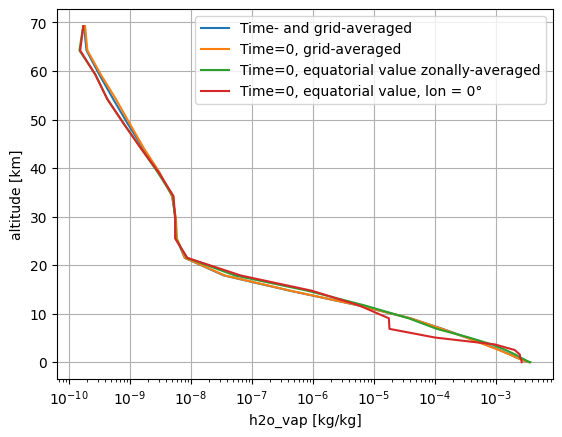

In [9]:
my_sim.plot_profile('h2o_vap',logx=True,label='Time- and grid-averaged')
my_sim.plot_profile('h2o_vap',t=0,logx=True,label='Time=0, grid-averaged')
my_sim.plot_profile('h2o_vap',t=0,lat=0,logx=True,label='Time=0, equatorial value zonally-averaged')
my_sim.plot_profile('h2o_vap',t=0,lat=0,lon=0,logx=True,label='Time=0, equatorial value, lon = 0°')
plt.legend()
plt.grid()

## Interactive visualization
Now we go fancy!

#### Define widgets
Let's define some widgets (see [here](https://ipywidgets.readthedocs.io/en/latest/) for documenttion on jupyter's widgets):

In [10]:
import ipywidgets as widgets

# Coordinates
w_lat = widgets.FloatSlider(min=-90, max=90, step=1, description="latitude")
w_lon = widgets.FloatSlider(min=-180, max=180, step=1, description="longitude")
w_alt = widgets.FloatSlider(min=0, max=max(my_sim.data["altitude"]), step=1, description="altitude")
w_time = widgets.FloatSlider(min=0, max=max(my_sim["Time"]), step=1, description="time")

# Fields
w_single_sp   = widgets.Select(options=my_sim.species, value="h2o_vap", description="species")
w_multiple_sp = widgets.SelectMultiple(options=my_sim.species, value=["h2o_vap"], description="species")
w_reactions   = widgets.SelectMultiple(options=my_sim.reactions.keys(), value=["co2 + hv -> co + o"], description="reactions")

# Miscelaneous
w_average = widgets.Checkbox(description='show average')

#### OH meridional slice at various longitudes
OH is a photolysis product with a short lifetime, so it exist only on the dayside. Scrolling through the longitudes will exhibit this dichotomy.

In [11]:
# Slice plotting unction
def make_slice(lon):
    my_sim.plot_meridional_slice('oh',t=0,lon=lon,logcb=True)

# Define interactive output
out = widgets.interactive_output(make_slice,{'lon':w_lon})

# Build the output frame
widgets.VBox([w_lon,out])

#### Water vapor atlas
We can have several action widgets

In [12]:
# Atlas plotting function
def make_atlas(t,alt):
    my_sim.plot_atlas('h2o_vap',t=t,alt=alt)
    plt.title('t='+str(int(t))+' sol, altitude='+str(int(alt))+' km')

# Define interactive output
out = widgets.interactive_output(make_atlas,{'t':w_time,'alt':w_alt})

# Build the output frame
widgets.VBox([w_time,w_alt,out])

#### Temperature profile at various times and locations

In [13]:
# Profile plotting unction
def make_prof(t,lon,lat,avg):
    my_sim.plot_profile('temp',t=t,lon=lon,lat=lat,label='lon='+str(int(lon))+'°, lat='+str(int(lat))+'°')
    if avg:
        my_sim.plot_profile('temp',t=t,label='average')
    plt.legend()
    plt.grid()

# Define interactive output
out = widgets.interactive_output(make_prof,{'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

# Build the output frame
widgets.HBox([widgets.VBox([w_time,w_lon,w_lat,w_average]),out])

#### Extensive species visualizer
Combining the above examples for arbitrary species

In [15]:
def make_visualizer(sp,t,alt):
    
    plt.subplot(131) # zonal average
    my_sim.plot_meridional_slice(sp,t=t,logcb=True)
    plt.plot([-90,90],[alt,alt],ls='--',lw=3,c='white')

    plt.subplot(132) # atlas
    my_sim.plot_atlas(sp,t=t,alt=alt)
    plt.title('t='+str(int(t))+' sol, altitude='+str(int(alt))+' km')

    plt.subplot(133) # profile
    my_sim.plot_profile('temp',t=t)
    plt.grid()

    plt.subplots_adjust(right=2)

out = widgets.interactive_output(make_visualizer,{'sp':w_single_sp,'t':w_time,'alt':w_alt})

widgets.HBox([widgets.VBox([w_single_sp,w_time,w_alt]),out])

#### Multi-species profiles
Shift+click to select multiple species (Command+click on Mac)

In [16]:
cmap = plt.get_cmap("tab10")
def make_sp_prof(sps,t,lon,lat,avg):

    for i,sp in enumerate(sps):
        my_sim.plot_profile(sp,t=t,lon=lon,lat=lat,logx=True,label=sp,c=cmap(i))
        if avg:
            my_sim.plot_profile(sp,t=t,logx=True,c=cmap(i),ls='--')
    if avg: # just for the legend
        plt.plot([],[],c='k',label='lon='+str(int(lon))+'°, lat='+str(int(lat))+'°')
        plt.plot([],[],ls='--',c='k',label='average')
        
    plt.legend()
    plt.grid()

out = widgets.interactive_output(make_sp_prof,{'sps':w_multiple_sp,'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

widgets.HBox([widgets.VBox([w_multiple_sp,w_time,w_lon,w_lat,w_average]),out])

#### Species-specific reaction rates

In [17]:
def make_reaction_rate_viz(sp,t):

    for r in my_sim.reactions:
        if sp in my_sim.reactions[r].products:
            my_sim.plot_profile('rate ('+r+')',t=t,logx=True,label=r)
        elif sp in my_sim.reactions[r].reactants:
            my_sim.plot_profile('rate ('+r+')',t=t,logx=True,ls='--',label=r)

    plt.legend()
    plt.grid()

out=widgets.interactive_output(make_reaction_rate_viz,{'sp':w_single_sp,'t':w_time})

widgets.HBox([widgets.VBox([w_single_sp,w_time]),out])

#### Profile with atlas locator
Here the atlas shows the column mass

In [18]:
def make_sp_prof_atlas(sp,t,lon,lat,avg):

    plt.subplot(121) # Vertical profile
    for r in my_sim.reactions:
        if sp in my_sim.reactions[r].products:
            my_sim.plot_profile('rate ('+r+')',t=t,logx=True,label=r)
        elif sp in my_sim.reactions[r].reactants:
            my_sim.plot_profile('rate ('+r+')',t=t,logx=True,ls='--',label=r)

    plt.legend()
    plt.grid()

    plt.subplot(122) # Atlas
    my_sim.plot_atlas(sp+'_col',t=t)
    plt.scatter([lon],[lat],marker='o',s=[100],c=['tab:red'])

    plt.subplots_adjust(right=2)

out = widgets.interactive_output(make_sp_prof_atlas,{'sp':w_single_sp,'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

widgets.HBox([widgets.VBox([w_single_sp,w_time,w_lon,w_lat,w_average]),out])

#### Species-specific reaction rates with atlas locator

In [19]:
def make_sp_rate_atlas(sp,t,lon,lat,avg):

    plt.subplot(121) # Vertical profile
    for r in my_sim.reactions:
        if sp in my_sim.reactions[r].products:
            my_sim.plot_profile('rate ('+r+')',t=t,lon=lon,lat=lat,logx=True,label=r)
        elif sp in my_sim.reactions[r].reactants:
            my_sim.plot_profile('rate ('+r+')',t=t,lon=lon,lat=lat,logx=True,ls='--',label=r)
        
    plt.legend()
    plt.grid()

    plt.subplot(122) # Atlas
    my_sim.plot_atlas(sp+'_col',t=t)
    plt.scatter([lon],[lat],marker='o',s=[100],c=['tab:red'])

    plt.subplots_adjust(right=2)

out = widgets.interactive_output(make_sp_prof_atlas,{'sp':w_single_sp,'t':w_time,'lon':w_lon,'lat':w_lat,'avg':w_average})

widgets.HBox([widgets.VBox([w_single_sp,w_time,w_lon,w_lat,w_average]),out])